# Microtask 2
---
Produce a chart showing the distribution of time-to-close (using the corresponding field in the GrimoireLab enriched index for GitHub issues) for issues already closed, and opened during the last six months.

In [15]:
from datetime import datetime
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

import subprocess
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Assuming we have a running instance of Elasticsearch locally at http://localhost:9200

In [2]:
# elasticsearch instance
es = Elasticsearch('http://localhost:9200', verify_certs=False)

The [grimoirelab-perceval](https://github.com/chaoss/grimoirelab-perceval) repository will be used

In [3]:
org = 'chaoss'
repo = 'grimoirelab-perceval'
token = ''

Run the `p2o.py` subprocess to generate the indices.

In [4]:
subprocess.run(['p2o.py', '--enrich', '--index', 'perceval_github_raw', '--index-enrich', 'perceval_github', '-e', 'http://localhost:9200', '--no_inc', '--debug', 'github', org, repo, '-t', token, '--sleep-for-rate'])

CompletedProcess(args=['p2o.py', '--enrich', '--index', 'perceval_github_raw', '--index-enrich', 'perceval_github', '-e', 'http://localhost:9200', '--no_inc', '--debug', 'github', 'chaoss', 'grimoirelab-perceval', '-t', '1be89fc7151192be77782ef93778861242a48925', '--sleep-for-rate'], returncode=0)

Frame a query for the required information using the `elasticsearch_dsl` module.

In [6]:
s = Search(using=es, index='perceval_github')
# filter by issues
s = s.filter('terms', item_type=['issue'])
# filter issues created in the last six months
s = s.filter('range', created_at={'gte' : 'now-6M'})
# get required fields
s = s.source(['time_to_close_days', 'time_open_days', 'item_type', 'created_at', 'closed_at', 'author_name', 'id_in_repo'])
# sort by creation date
s = s.sort({'created_at': {'order': 'asc'}})
# limit the number of results
s = s[0:1000]

In [12]:
# execute the query
result = s.execute()

In [13]:
# convert to dictionary and keep only relevant information
result = result.to_dict()['hits']['hits']
result

[{'_id': '6eae638c3522c4c9ee2478686b7bad08876b2476',
  '_index': 'perceval_github',
  '_score': None,
  '_source': {'author_name': 'Santiago Dueñas',
   'closed_at': '2017-09-15T08:45:58Z',
   'created_at': '2017-09-13T09:55:38Z',
   'id_in_repo': '155',
   'item_type': 'issue',
   'time_open_days': 1.95,
   'time_to_close_days': 1.95},
  '_type': 'items',
  'sort': [1505296538000]},
 {'_id': '3d3e02bda92ce73b96056b27052aea783f2d6e43',
  '_index': 'perceval_github',
  '_score': None,
  '_source': {'author_name': 'Santiago Dueñas',
   'closed_at': '2017-10-07T14:41:19Z',
   'created_at': '2017-09-13T10:01:38Z',
   'id_in_repo': '156',
   'item_type': 'issue',
   'time_open_days': 24.19,
   'time_to_close_days': 24.19},
  '_type': 'items',
  'sort': [1505296898000]},
 {'_id': '39b0d3f62a402c3a11997f199af27ddd0e0fab05',
  '_index': 'perceval_github',
  '_score': None,
  '_source': {'author_name': 'Jesus M. Gonzalez-Barahona',
   'closed_at': None,
   'created_at': '2017-09-19T21:52:22Z',


In [16]:
# issues
issues = [issue['_source'] for issue in result]
issues = pd.DataFrame(issues)
issues.head()

,author_name,closed_at,created_at,id_in_repo,item_type,time_open_days,time_to_close_days
0,Santiago Dueñas,2017-09-15T08:45:58Z,2017-09-13T09:55:38Z,155,issue,1.95,1.95
1,Santiago Dueñas,2017-10-07T14:41:19Z,2017-09-13T10:01:38Z,156,issue,24.19,24.19
2,Jesus M. Gonzalez-Barahona,None,2017-09-19T21:52:22Z,160,issue,170.99,NaN
3,Alvaro del Castillo,2017-09-27T11:24:36Z,2017-09-22T04:45:33Z,162,issue,5.28,5.28
4,Alvaro del Castillo,2017-11-07T12:07:50Z,2017-09-25T21:02:07Z,165,issue,42.63,42.63


In [17]:
issues

,author_name,closed_at,created_at,id_in_repo,item_type,time_open_days,time_to_close_days
0,Santiago Dueñas,2017-09-15T08:45:58Z,2017-09-13T09:55:38Z,155,issue,1.95,1.95
1,Santiago Dueñas,2017-10-07T14:41:19Z,2017-09-13T10:01:38Z,156,issue,24.19,24.19
2,Jesus M. Gonzalez-Barahona,None,2017-09-19T21:52:22Z,160,issue,170.99,NaN
3,Alvaro del Castillo,2017-09-27T11:24:36Z,2017-09-22T04:45:33Z,162,issue,5.28,5.28
4,Alvaro del Castillo,2017-11-07T12:07:50Z,2017-09-25T21:02:07Z,165,issue,42.63,42.63
5,Alvaro del Castillo,2017-09-29T17:21:43Z,2017-09-26T15:04:45Z,167,issue,3.10,3.10
6,Santiago Dueñas,None,2017-09-27T11:44:00Z,168,issue,163.41,NaN
7,Alvaro del Castillo,2017-10-10T14:27:30Z,2017-10-09T16:20:16Z,174,issue,0.92,0.92
8,Alvaro del Castillo,2017-10-24T12:30:36Z,2017-10-09T18:22:00Z,175,issue,14.76,14.76
9,Alberto Martín,2017-10-16T19:13:11Z,2017-10-11T12:24:04Z,178,issue,5.28,5.28


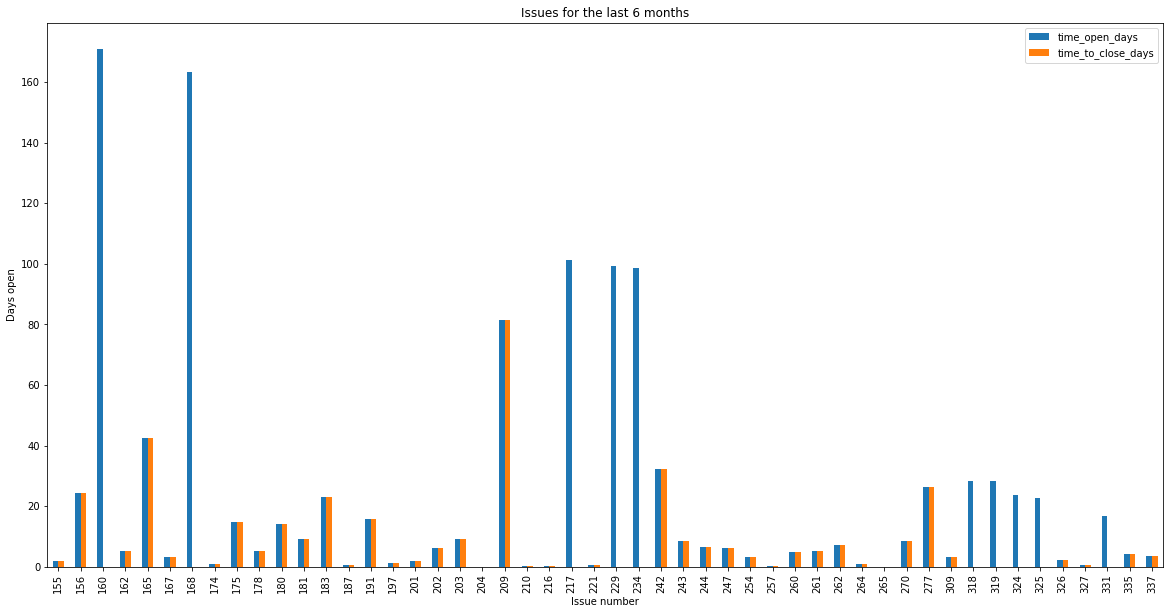

In [19]:
ax = issues.plot(x=issues['id_in_repo'], kind='bar', figsize=(20, 10))
ax.set_title('Issues for the last 6 months')
ax.set_xlabel('Issue number')
ax.set_ylabel('Days open')
plt.show()